In [1]:
# <%matplotlib inline> goes well for vscode
# %matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data preprocessing before use
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
# load the dataset
from data_processing import data_loading, data_cutoff, test_data_prepare

doe_num=4
# get to know the start position and number of segments for each drilling file
file_base="../data/dataset/DoE/"+str(doe_num) + "/"
file_indice=file_base+"Drilling_layers_indice.csv"
df= pd.read_csv(file_indice, header=None)
df.columns= ['start_seg', 'nb_segs']
start_segs= df['start_seg'].values
nb_segs= df['nb_segs'].values

file_data_base= file_base + "Drilling_layers_"
file_label_base= file_base+"Pulse_label_para_" + str(doe_num) + "_doe_"

vol_all=np.empty((0, 200))
cur_all=np.empty((0, 200))
labels_all=np.empty((0, 1))

numbers_to_cutoff=[
    [690000, 0, 360000], [500000, 0, 360000], [380000, 0, 360000], [1099000, 0, 359000, 42000, 63000, 11000],
    [970000, 0, 360000], [1070000, 0, 360000], [1130000, 0, 360000], [1150000, 0, 360000]
]
vols_max= [170, 170, 170, 110, 110, 170, 110, 110]
curs_max= [30, 30, 30, 30, 25, 30, 25, 25]

for i in range(3, 4, 1):
    if i==0:
        number_to_cutoff=[88000, 1000]
    elif i==1 or i==2 or i==3:
        number_to_cutoff= numbers_to_cutoff[doe_num-1]
    
    file_data= file_data_base + str(i+1) + ".tdms"
    file_label= file_label_base + str(i+1) + ".csv"
    
    vol, cur, labels= data_loading(file_data, file_label,
                            start_seg=start_segs[i], nb_segs=nb_segs[i])
    vol_all=   np.concatenate((vol_all, vol), axis=0)
    cur_all=   np.concatenate((cur_all, cur), axis=0)
    labels_all=np.concatenate((labels_all, labels), axis=0)
    del vol, cur, labels

vol_all, cur_all, labels_all= data_cutoff(vol_all, cur_all, labels_all,
                                        number_to_cutoff=number_to_cutoff)
X_test, y_test= test_data_prepare(
    vol_all, cur_all, labels_all, vol_max=vols_max[doe_num-1], cur_max=curs_max[doe_num-1], cur_min=0
)

Good! we now have 1624000 number of pulses!
We have retrieved 1624000 pulses!


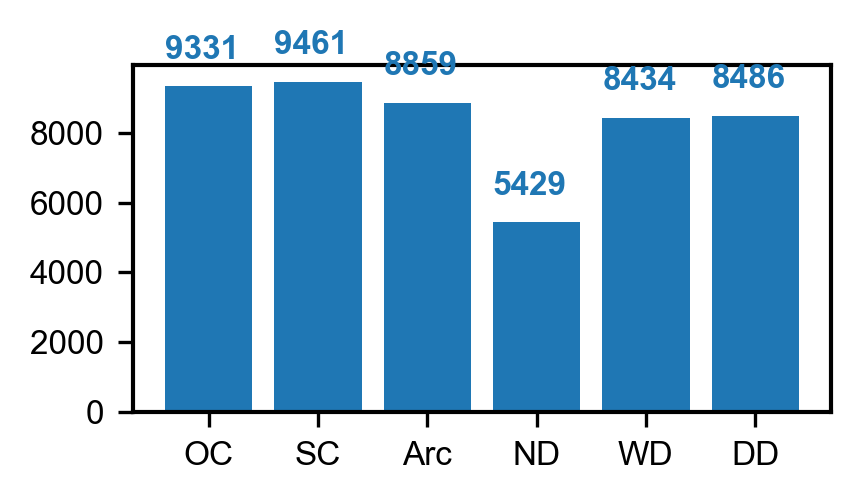

In [3]:
label_names=['OC', 'SC', 'Arc', 'ND', 'WD', 'DD']

counts=[]
for i in range(len(label_names)):
    counts.append(np.count_nonzero(labels_all[:]==i))

import matplotlib
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams.update({'axes.linewidth': 1})

fig = plt.figure(figsize=(3, 1.5), dpi=300)
plt.bar(label_names, counts)
for i, v in enumerate(counts):
    plt.text(i-0.4, v+800, str(v), color='tab:blue', fontweight='bold')

In [ ]:
# load the trained model
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'lib/')))
# from attention import Attention
from my_attention import Attention

mdl= tf.keras.models.load_model("../data/model/tcn/comparison/mdl_tcn_v0.h5", custom_objects={'Attention': Attention}) 
# mdl= tf.keras.models.load_model("../data/model/lstm/comparison/mdl_bilstm_v0.h5", custom_objects={'Attention': Attention}) 

In [ ]:
from tensorflow.keras.layers import Flatten
x= mdl.get_layer('layer_normalization_1').output
x= Flatten()(x)
model= keras.models.Model([mdl.input], 
            [x])
cluster= model.predict(X_test)
cluster.shape

In [ ]:
# print(encoder_out_list[0].shape)
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, IncrementalPCA, PCA
from IPython.display import clear_output
np.random.seed(888)
n_components_first = 30
n_components_second= 2

tsne = TSNE(n_components_second, perplexity=80)
embed_second= tsne.fit_transform(cluster)
clear_output()

In [29]:
import pickle

# with open('../data/interpet/tsne_bilstm_doe4_output.pkl', 'wb') as f:
with open('../data/interpet/tsne_hdcnn_doe4_embed.pkl', 'wb') as f:
    pickle.dump(embed_second, f)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6), dpi=300)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams.update({'axes.linewidth': 1})
# plot the scatter 
color= ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:olive']
label_names=['OC', 'SC', 'Arc', 'ND', 'WD', 'DD']

n_classes= 6
palette = np.array(sns.color_palette("hls", n_classes))

for i in range(n_classes):
    index= np.argmax(y_test, axis=1)
    class_index= np.where(index == i)
    plt.scatter(embed_second[class_index, 0], embed_second[class_index, 1], 
                color=palette[i], cmap=plt.cm.get_cmap('Paired'))
plt.legend(label_names, fontsize=12)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()